In [1]:
from typing import List
import numpy as np
import torch.cuda
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import copy
import nashpy as nash

from utils.logger import Logger
from utils.io_utils import save_code
from utils.utils import model_comparison, generate_outputs_from_distribution
from utils.plot import two_action_prob_plot

from algorithm import RewardModel, MaximumLikelihoodEstimator,PolicyGradientOptimizer,DirectPreferenceOptimizer, SelfPlayPreferenceOptimizer, SPPOClosedForm
from policy import UniformPolicyModel,PolicyModel,Ref_PolicyModel
from utils.collect_data import collect_preference_data, NonMonotonicScalarToVectorNN, check_data_consistency, check_cyclic_order

In [2]:
from datetime import datetime

np.random.seed(5)

current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
log_dir = f"./logs/test_{current_time}"
save_code(log_dir)

logger = Logger(log_dir)
writer = SummaryWriter(log_dir)

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

In [3]:
state_dim = 1
actions = [-10,0,10]

### Collect data

In [4]:
torch.manual_seed(5)
feature_func = NonMonotonicScalarToVectorNN()
pref_dataset, p_list = collect_preference_data(actions,60,feature_func)

In [5]:
p_list

array([[0.5       , 0.75489888, 0.44118223],
       [0.24510112, 0.5       , 0.83795365],
       [0.55881777, 0.16204635, 0.5       ]])

In [6]:
pref_dataset

[Transition(state=array([0]), action_0=0, action_1=-10, pref=1, chosen_probs=0.24510111981513732),
 Transition(state=array([0]), action_0=-10, action_1=0, pref=1, chosen_probs=0.7548988801848626),
 Transition(state=array([0]), action_0=0, action_1=10, pref=1, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=0, action_1=10, pref=0, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=0, action_1=10, pref=1, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=0, action_1=10, pref=1, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=-10, action_1=10, pref=0, chosen_probs=0.44118222864585355),
 Transition(state=array([0]), action_0=-10, action_1=0, pref=0, chosen_probs=0.7548988801848626),
 Transition(state=array([0]), action_0=10, action_1=-10, pref=1, chosen_probs=0.5588177713541465),
 Transition(state=array([0]), action_0=-10, action_1=10, pref=1, chosen_probs=0.44118222864585355),
 Transition(state=

In [7]:
action_to_index = {-10: 0, 0: 1, 10: 2}

states = torch.cat([torch.tensor(x.state) for x in pref_dataset], dim=0)

positive_actions = torch.cat(
    [torch.tensor(action_to_index[x.action_1] if x.pref == 1 else action_to_index[x.action_0]).unsqueeze(0) for x in pref_dataset],
    dim=0
)

negative_actions = torch.cat(
    [torch.tensor(action_to_index[x.action_0] if x.pref == 1 else action_to_index[x.action_1]).unsqueeze(0) for x in pref_dataset],
    dim=0
)

print(f"states: {states}")
print(f"positive_actions: {positive_actions}")
print(f"negative_actions: {negative_actions}")

# check transition and consistency
print(f"check transition: {check_cyclic_order(p_list,actions)}")
print(f"check data consistency: {check_data_consistency(pref_dataset)}")

states: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
positive_actions: tensor([0, 1, 2, 1, 2, 2, 0, 0, 0, 2, 1, 1, 2, 1, 0, 1, 0, 2, 0, 0, 1, 2, 2, 2,
        2, 2, 1, 0, 1, 2, 2, 1, 1, 0, 0, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 1, 1, 2,
        0, 1, 0, 0, 1, 0, 2, 2, 1, 2, 1, 0])
negative_actions: tensor([1, 0, 1, 2, 1, 1, 2, 1, 2, 0, 2, 2, 1, 0, 1, 2, 1, 1, 1, 2, 0, 0, 0, 1,
        1, 1, 0, 1, 2, 0, 0, 0, 2, 1, 2, 1, 0, 1, 1, 1, 2, 2, 0, 2, 1, 2, 0, 1,
        1, 2, 2, 2, 0, 2, 1, 1, 2, 0, 0, 1])
check transition: (True, ('-10', '0', '10'))
check data consistency: 0.8


## Nash equilibrium

In [8]:
# compute nash equilibrium

# A = np.array([
#     [0.5, 0.1, 0.8],
#     [0.9, 0.5, 0.1],
#     [0.2, 0.9, 0.5]
# ])


game = nash.Game(p_list, -p_list)

equilibria = list(game.support_enumeration())

for eq in equilibria:
    print("Nash equilibrium of this game: ", eq[0])  

Nash equilibrium of this game:  [0.51859606 0.09025695 0.39114699]


In [9]:
# We use action 0 and action 1 to plot the scatter plot
nash_point= [eq[0][0],eq[0][1]]
nash_point

[0.5185960617933865, 0.09025694564670378]

## RLHF

In [10]:
learned_reward_model = RewardModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
)

In [11]:
mle_learner = MaximumLikelihoodEstimator(
    actions,
    learned_reward_model,
    learning_rate=1e-4,
    batch_size=64,
    logger=logger,
)

In [12]:
import time  # for seed

torch.manual_seed(time.time())
mle_learner.optimize(
    states, positive_actions, negative_actions, num_epochs=20
)

2024-11-20 17:52:27,281 - /home/hanwen/policy_optimization/exp/algorithm.py[line:124] - INFO: [Reward] Epoch 0 loss: 0.6915 acc: 0.52
2024-11-20 17:52:27,287 - /home/hanwen/policy_optimization/exp/algorithm.py[line:124] - INFO: [Reward] Epoch 2 loss: 0.6910 acc: 0.52
2024-11-20 17:52:27,293 - /home/hanwen/policy_optimization/exp/algorithm.py[line:124] - INFO: [Reward] Epoch 4 loss: 0.6905 acc: 0.52
2024-11-20 17:52:27,298 - /home/hanwen/policy_optimization/exp/algorithm.py[line:124] - INFO: [Reward] Epoch 6 loss: 0.6902 acc: 0.52
2024-11-20 17:52:27,303 - /home/hanwen/policy_optimization/exp/algorithm.py[line:124] - INFO: [Reward] Epoch 8 loss: 0.6898 acc: 0.55
2024-11-20 17:52:27,308 - /home/hanwen/policy_optimization/exp/algorithm.py[line:124] - INFO: [Reward] Epoch 10 loss: 0.6896 acc: 0.55
2024-11-20 17:52:27,313 - /home/hanwen/policy_optimization/exp/algorithm.py[line:124] - INFO: [Reward] Epoch 12 loss: 0.6894 acc: 0.55
2024-11-20 17:52:27,318 - /home/hanwen/policy_optimization/e

In [13]:
# pg
policy = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

In [14]:
ref_policy = UniformPolicyModel(
    action_num=len(actions),
    device=device
).to(device)

ref_policy2 = Ref_PolicyModel(
    len(actions),torch.tensor([[0.7,0.2,0.1]]),device).to(device)

ref_policy3 = Ref_PolicyModel(
    len(actions),torch.tensor([[1.0,0.0,0.0]]),device).to(device)

ref_policy4 = Ref_PolicyModel(
    len(actions),torch.tensor([[0.1,0.3,0.6]]),device).to(device)

print(ref_policy(torch.tensor([[0.0]])))
print(ref_policy2(torch.tensor([[0.0]])))
print(ref_policy3(torch.tensor([[0.0]])))
print(ref_policy4(torch.tensor([[0.0]])))

tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([[0.7000, 0.2000, 0.1000]], device='cuda:0')
tensor([[1., 0., 0.]], device='cuda:0')
tensor([[0.1000, 0.3000, 0.6000]], device='cuda:0')


In [15]:
states = torch.zeros(len(pref_dataset), 1, dtype=torch.float32).to(device) 
states.shape

torch.Size([60, 1])

In [16]:
policy_optimizer = PolicyGradientOptimizer(
    policy=policy,
    reward_model=learned_reward_model,
    ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    logger=logger,
    nash_point = nash_point
)

2024-11-20 17:52:27,473 - /home/hanwen/policy_optimization/exp/algorithm.py[line:193] - INFO: [Policy] Epoch 0 loss: -0.2026 reward: 0.2026 ref_reward: 0.1991 improvement: 1.75%


2024-11-20 17:52:27,480 - /home/hanwen/policy_optimization/exp/algorithm.py[line:193] - INFO: [Policy] Epoch 2 loss: -0.2076 reward: 0.2076 ref_reward: 0.1991 improvement: 4.25%
2024-11-20 17:52:27,487 - /home/hanwen/policy_optimization/exp/algorithm.py[line:193] - INFO: [Policy] Epoch 4 loss: -0.2125 reward: 0.2125 ref_reward: 0.1991 improvement: 6.73%
2024-11-20 17:52:27,493 - /home/hanwen/policy_optimization/exp/algorithm.py[line:193] - INFO: [Policy] Epoch 6 loss: -0.2175 reward: 0.2175 ref_reward: 0.1991 improvement: 9.21%
2024-11-20 17:52:27,499 - /home/hanwen/policy_optimization/exp/algorithm.py[line:193] - INFO: [Policy] Epoch 8 loss: -0.2224 reward: 0.2224 ref_reward: 0.1991 improvement: 11.69%
2024-11-20 17:52:27,505 - /home/hanwen/policy_optimization/exp/algorithm.py[line:193] - INFO: [Policy] Epoch 10 loss: -0.2273 reward: 0.2273 ref_reward: 0.1991 improvement: 14.14%
2024-11-20 17:52:27,512 - /home/hanwen/policy_optimization/exp/algorithm.py[line:193] - INFO: [Policy] Epoc

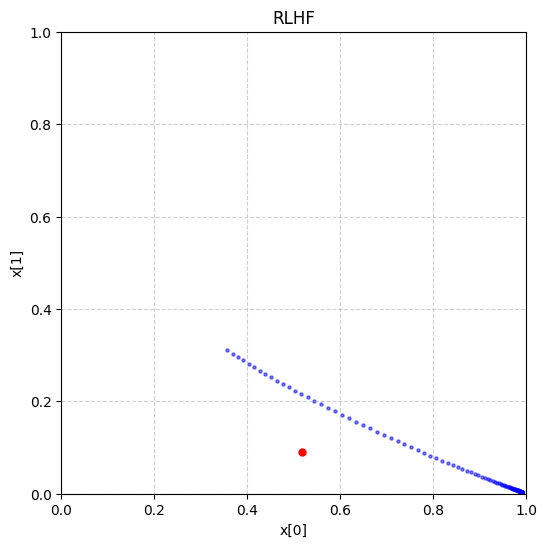

In [17]:
policy_optimizer.optimize(states=states, num_epochs=100)

In [18]:
state_0 = torch.tensor([0.0], dtype=torch.float32).to(device)
action_0 = torch.tensor([1,0,0], dtype=torch.float32).to(device)
action_1 = torch.tensor([0,0,1], dtype=torch.float32).to(device)
action_2 = torch.tensor([0,1,0], dtype=torch.float32).to(device)
print(learned_reward_model(state_0,action_0))
print(learned_reward_model(state_0,action_1))
print(learned_reward_model(state_0,action_2))

tensor([0.3088], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.1832], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.0883], device='cuda:0', grad_fn=<ViewBackward0>)


In [19]:
# output the probabilities of each action from the learned policy
test_state = torch.tensor([[0.0]], dtype=torch.float32).to(device)  

with torch.no_grad():
    action_probs = policy(test_state)
    action_probs = action_probs.cpu().numpy()[0]  

actions = [-10, 0, 10]  
for action, prob in zip(actions, action_probs):
    print(f"P(action={action}) = {prob:.3f}")

# output the probabilities of each action from the reference policy
ref_probs = ref_policy(test_state).cpu().numpy()[0]
print("\nUniform policy probabilities:")
for action, prob in zip(actions, ref_probs):
    print(f"P(action={action}) = {prob:.3f}")

P(action=-10) = 0.991
P(action=0) = 0.003
P(action=10) = 0.005

Uniform policy probabilities:
P(action=-10) = 0.333
P(action=0) = 0.333
P(action=10) = 0.333


In [20]:
# compare the learned policy with the reference policy
score = model_comparison(policy, ref_policy,feature_func)
print(f"\nRLHF model and base model comparison score: {score:.3f}")


RLHF model and base model comparison score: 0.083


/home/hanwen/policy_optimization/exp/utils/utils.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


## DPO

In [21]:
policy2 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

In [22]:
dpo_optimizer = DirectPreferenceOptimizer(
    policy=policy2,
    ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

2024-11-20 17:52:28,125 - /home/hanwen/policy_optimization/exp/algorithm.py[line:315] - INFO: [Policy] Epoch: 0 loss: 0.6931 grad norm: 0.0305 
2024-11-20 17:52:28,141 - /home/hanwen/policy_optimization/exp/algorithm.py[line:315] - INFO: [Policy] Epoch: 5 loss: 0.6906 grad norm: 0.0212 
2024-11-20 17:52:28,156 - /home/hanwen/policy_optimization/exp/algorithm.py[line:315] - INFO: [Policy] Epoch: 10 loss: 0.6892 grad norm: 0.0113 
2024-11-20 17:52:28,171 - /home/hanwen/policy_optimization/exp/algorithm.py[line:315] - INFO: [Policy] Epoch: 15 loss: 0.6888 grad norm: 0.0015 
2024-11-20 17:52:28,186 - /home/hanwen/policy_optimization/exp/algorithm.py[line:315] - INFO: [Policy] Epoch: 20 loss: 0.6890 grad norm: 0.0085 
2024-11-20 17:52:28,200 - /home/hanwen/policy_optimization/exp/algorithm.py[line:315] - INFO: [Policy] Epoch: 25 loss: 0.6890 grad norm: 0.0080 
2024-11-20 17:52:28,214 - /home/hanwen/policy_optimization/exp/algorithm.py[line:315] - INFO: [Policy] Epoch: 30 loss: 0.6889 grad n

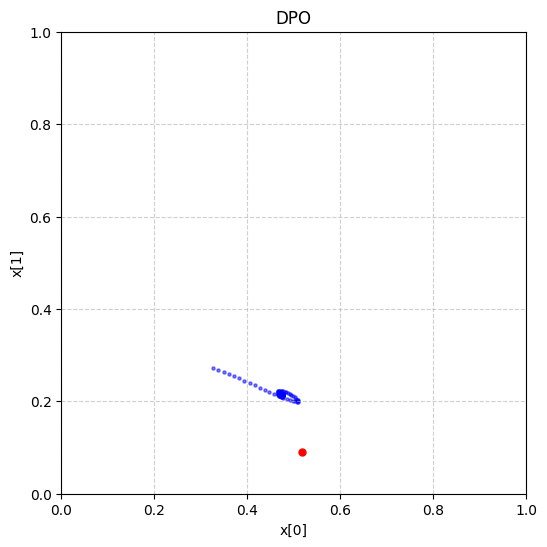

In [23]:
dpo_optimizer.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    num_epochs=100
)

In [24]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    action_probs = policy2(test_state)
    print("\nLearned policy probabilities:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
# compare the learned policy with the reference policy
score = model_comparison(policy2, ref_policy,feature_func)
print(f"\nDPO model and base model comparison score: {score:.3f}")


Learned policy probabilities:
P(action=-10) = 0.475
P(action=0) = 0.215
P(action=10) = 0.310

DPO model and base model comparison score: 0.037


## SPPO

In [25]:
policy3 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

In [26]:
chosen_probs = torch.tensor([x.chosen_probs for x in pref_dataset], dtype=torch.float32).to(device)

In [27]:
sppo_optimizer = SelfPlayPreferenceOptimizer(
    policy=policy3,
    ref_policy=ref_policy2,
    learning_rate=1e-2,
    batch_size=64,
    eta=1e-3,  
    logger=logger,
    nash_point = nash_point
)

2024-11-20 17:52:28,624 - /home/hanwen/policy_optimization/exp/algorithm.py[line:433] - INFO: [Policy] Epoch: 0 loss: 0.1257 grad norm: 0.4225 


2024-11-20 17:52:28,647 - /home/hanwen/policy_optimization/exp/algorithm.py[line:433] - INFO: [Policy] Epoch: 5 loss: 0.0025 grad norm: 0.0738 
2024-11-20 17:52:28,668 - /home/hanwen/policy_optimization/exp/algorithm.py[line:433] - INFO: [Policy] Epoch: 10 loss: 0.0025 grad norm: 0.0541 
2024-11-20 17:52:28,687 - /home/hanwen/policy_optimization/exp/algorithm.py[line:433] - INFO: [Policy] Epoch: 15 loss: 0.0008 grad norm: 0.0292 
2024-11-20 17:52:28,705 - /home/hanwen/policy_optimization/exp/algorithm.py[line:433] - INFO: [Policy] Epoch: 20 loss: 0.0006 grad norm: 0.0339 
2024-11-20 17:52:28,724 - /home/hanwen/policy_optimization/exp/algorithm.py[line:433] - INFO: [Policy] Epoch: 25 loss: 0.0002 grad norm: 0.0146 
2024-11-20 17:52:28,743 - /home/hanwen/policy_optimization/exp/algorithm.py[line:433] - INFO: [Policy] Epoch: 30 loss: 0.0002 grad norm: 0.0175 
2024-11-20 17:52:28,762 - /home/hanwen/policy_optimization/exp/algorithm.py[line:433] - INFO: [Policy] Epoch: 35 loss: 0.0001 grad 

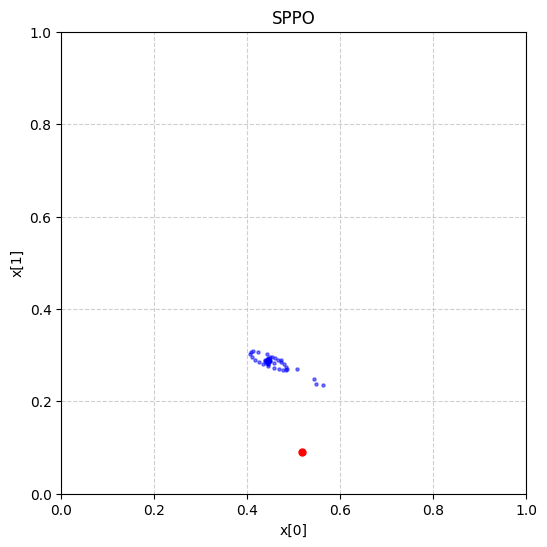

In [28]:
sppo_optimizer.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    chosen_probs=chosen_probs,
    num_epochs=100
)

In [29]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    action_probs = policy3(test_state)
    print("\nLearned policy probabilities:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
# compare the learned policy with the reference policy
score = model_comparison(policy3, ref_policy,feature_func)
print(f"\nSPPO model and base model comparison score: {score:.3f}")


Learned policy probabilities:
P(action=-10) = 0.445
P(action=0) = 0.288
P(action=10) = 0.267

SPPO model and base model comparison score: -0.005


## SPPO Closed-form solution

In [59]:
sppo_closed_form = SPPOClosedForm(
    ref_policy=ref_policy,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point
)

2024-11-20 17:55:54,571 - /home/hanwen/policy_optimization/exp/algorithm.py[line:509] - INFO: Iteration 0: ref_distribution = tensor([0.3333, 0.3333, 0.3333], device='cuda:0'), new_distribution = tensor([0.3341, 0.3341, 0.3318], device='cuda:0')
2024-11-20 17:55:54,575 - /home/hanwen/policy_optimization/exp/algorithm.py[line:509] - INFO: Iteration 1: ref_distribution = tensor([0.3341, 0.3341, 0.3318], device='cuda:0'), new_distribution = tensor([0.3343, 0.3351, 0.3305], device='cuda:0')
2024-11-20 17:55:54,579 - /home/hanwen/policy_optimization/exp/algorithm.py[line:509] - INFO: Iteration 2: ref_distribution = tensor([0.3343, 0.3351, 0.3305], device='cuda:0'), new_distribution = tensor([0.3350, 0.3359, 0.3290], device='cuda:0')
2024-11-20 17:55:54,583 - /home/hanwen/policy_optimization/exp/algorithm.py[line:509] - INFO: Iteration 3: ref_distribution = tensor([0.3350, 0.3359, 0.3290], device='cuda:0'), new_distribution = tensor([0.3348, 0.3372, 0.3280], device='cuda:0')
2024-11-20 17:55

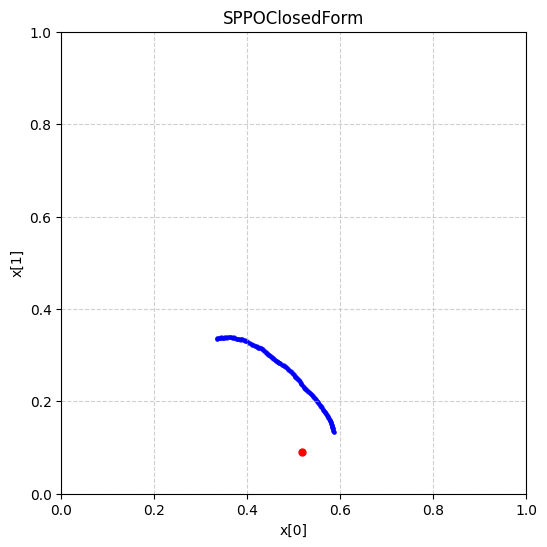

In [60]:
sppo_distribution = sppo_closed_form.optimize(
    p_list=p_list,
    num_iters=300
)   

In [62]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    action_probs = policy(test_state)
    print("\nLearned policy probabilities(RLHF):")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")

    action_probs2 = policy2(test_state)
    print("\nLearned policy probabilities(DPO):")
    for action, prob in zip(actions, action_probs2[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
    action_probs3 = policy3(test_state)
    print("\nLearned policy probabilities(SPPO):")
    for action, prob in zip(actions, action_probs3[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    
    action_probs4 = sppo_distribution
    print("\nLearned policy probabilities(SPPO-ClosedForm):")
    for action, prob in zip(actions, action_probs4.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        


Learned policy probabilities(RLHF):
P(action=-10) = 0.991
P(action=0) = 0.003
P(action=10) = 0.005

Learned policy probabilities(DPO):
P(action=-10) = 0.475
P(action=0) = 0.215
P(action=10) = 0.310

Learned policy probabilities(SPPO):
P(action=-10) = 0.445
P(action=0) = 0.288
P(action=10) = 0.267

Learned policy probabilities(SPPO-ClosedForm):
P(action=-10) = 0.586
P(action=0) = 0.134
P(action=10) = 0.280
